### Open this notebook in Colab and connect to GPU

In [18]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

# prevent ultralytics from tracking your activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.9.12 torch-2.0.0 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 448.2/460.4 GB disk)


#### 1. Load datasets

In [19]:
# Load player dataset
!curl -L "https://app.roboflow.com/ds/igCstoe8Mj?key=yu5jsVVWYs" > roboflow.zip; mkdir -p player_dataset && unzip roboflow.zip -d player_dataset; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0    872      0  0:00:01  0:00:01 --:--:--   873
100 81.5M  100 81.5M    0     0   976k      0  0:01:25  0:01:25 --:--:-- 1082k0:00:12  0:01:30  711k    0   698k      0  0:01:59  0:00:30  0:01:29  513k1:52  0:00:51  0:01:01 1062k
Archive:  roboflow.zip
  inflating: player_dataset/README.dataset.txt  
  inflating: player_dataset/README.roboflow.txt  
  inflating: player_dataset/data.yaml  
   creating: player_dataset/test/
   creating: player_dataset/test/images/
 extracting: player_dataset/test/images/08fd33_3_6_png.rf.fe65e49234932c0021119e2f233540c4.jpg  
 extracting: player_dataset/test/images/08fd33_9_3_png.rf.ac64adaedb504f523eaf4b8d0b038606.jpg  
 extracting: player_dataset/test/images/40cd38_7_6_png.rf.2f65a0966cc3340b68fda6f1e953d7f9.jpg  
 extracting: player_dataset/test/images/42ba34_1_5_png

In [20]:
import pandas as pd
import os
from pathlib import Path

# Function to load dataset split into a dataframe
def load_dataset_split(split_name):
    """
    Load images and labels from a dataset split into a dataframe.
    
    Args:
        split_name: Name of the split ('train', 'valid', or 'test')
    
    Returns:
        DataFrame with columns: image_path, label_path, filename, split
    """
    split_dir = Path(split_name)
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    
    # Get all image files
    image_files = sorted(images_dir.glob('*.jpg'))
    
    data = []
    for img_path in image_files:
        # Get corresponding label file (same name but .txt extension)
        label_filename = img_path.stem + '.txt'
        label_path = labels_dir / label_filename
        
        data.append({
            'image_path': str(img_path),
            'label_path': str(label_path) if label_path.exists() else None,
            'filename': img_path.name,
            'split': split_name
        })
    
    return pd.DataFrame(data)

# Load train, validation, and test sets
train_df = load_dataset_split('player_dataset/train')
valid_df = load_dataset_split('player_dataset/valid')
test_df = load_dataset_split('player_dataset/test')

# Display summary
print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(valid_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nTotal samples: {len(train_df) + len(valid_df) + len(test_df)}")

# Display first few rows of each dataframe
print("\n=== Train DataFrame (first 5 rows) ===")
print(train_df.head())
print("\n=== Validation DataFrame (first 5 rows) ===")
print(valid_df.head())
print("\n=== Test DataFrame (first 5 rows) ===")
print(test_df.head())


Train set: 298 samples
Validation set: 49 samples
Test set: 25 samples

Total samples: 372

=== Train DataFrame (first 5 rows) ===
                                          image_path  \
0  player_dataset/train/images/08fd33_0_10_png.rf...   
1  player_dataset/train/images/08fd33_0_1_png.rf....   
2  player_dataset/train/images/08fd33_0_2_png.rf....   
3  player_dataset/train/images/08fd33_0_3_png.rf....   
4  player_dataset/train/images/08fd33_0_4_png.rf....   

                                          label_path  \
0  player_dataset/train/labels/08fd33_0_10_png.rf...   
1  player_dataset/train/labels/08fd33_0_1_png.rf....   
2  player_dataset/train/labels/08fd33_0_2_png.rf....   
3  player_dataset/train/labels/08fd33_0_3_png.rf....   
4  player_dataset/train/labels/08fd33_0_4_png.rf....   

                                            filename                 split  
0  08fd33_0_10_png.rf.a523b717cb83e4a16b54f368588...  player_dataset/train  
1  08fd33_0_1_png.rf.d3884b2cd3694c693e80

In [21]:
import numpy as np

# Define class names from data.yaml
CLASS_NAMES = ['ball', 'goalkeeper', 'player', 'referee']

def parse_yolo_label(label_path):
    """
    Parse a YOLO format label file.
    
    Args:
        label_path: Path to the label file (.txt)
    
    Returns:
        List of dictionaries, each containing:
        - class_id: int
        - class_name: str
        - x_center: float (normalized 0-1)
        - y_center: float (normalized 0-1)
        - width: float (normalized 0-1)
        - height: float (normalized 0-1)
    """
    if label_path is None or not Path(label_path).exists():
        return []
    
    annotations = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                annotations.append({
                    'class_id': class_id,
                    'class_name': CLASS_NAMES[class_id],
                    'x_center': x_center,
                    'y_center': y_center,
                    'width': width,
                    'height': height
                })
    
    return annotations

def add_label_info(df):
    """
    Add label information to the dataframe.
    
    Args:
        df: DataFrame with label_path column
    
    Returns:
        DataFrame with additional columns:
        - annotations: list of all annotations in the image
        - num_objects: total number of objects
        - num_balls, num_goalkeepers, num_players, num_referees: count per class
    """
    df = df.copy()
    
    # Parse all labels
    df['annotations'] = df['label_path'].apply(parse_yolo_label)
    
    # Count total objects
    df['num_objects'] = df['annotations'].apply(len)
    
    # Count per class
    for class_id, class_name in enumerate(CLASS_NAMES):
        df[f'num_{class_name}s'] = df['annotations'].apply(
            lambda anns: sum(1 for ann in anns if ann['class_id'] == class_id)
        )
    
    return df

# Add label information to all dataframes
print("Parsing labels...")
train_df = add_label_info(train_df)
valid_df = add_label_info(valid_df)
test_df = add_label_info(test_df)

print("\n=== Dataset Statistics ===")
for split_name, df in [('Train', train_df), ('Validation', valid_df), ('Test', test_df)]:
    print(f"\n{split_name} Set:")
    print(f"  Total images: {len(df)}")
    print(f"  Total objects: {df['num_objects'].sum()}")
    print(f"  Avg objects per image: {df['num_objects'].mean():.2f}")
    print(f"  Objects per class:")
    for class_name in CLASS_NAMES:
        total = df[f'num_{class_name}s'].sum()
        print(f"    {class_name}: {total}")

# Show updated dataframe with label info
print("\n=== Train DataFrame with Label Info (first 5 rows) ===")
print(train_df[['filename', 'num_objects', 'num_balls', 'num_goalkeepers', 'num_players', 'num_referees']].head())


Parsing labels...

=== Dataset Statistics ===

Train Set:
  Total images: 298
  Total objects: 7133
  Avg objects per image: 23.94
  Objects per class:
    ball: 258
    goalkeeper: 230
    player: 5955
    referee: 690

Validation Set:
  Total images: 49
  Total objects: 1174
  Avg objects per image: 23.96
  Objects per class:
    ball: 45
    goalkeeper: 39
    player: 973
    referee: 117

Test Set:
  Total images: 25
  Total objects: 599
  Avg objects per image: 23.96
  Objects per class:
    ball: 24
    goalkeeper: 19
    player: 500
    referee: 56

=== Train DataFrame with Label Info (first 5 rows) ===
                                            filename  num_objects  num_balls  \
0  08fd33_0_10_png.rf.a523b717cb83e4a16b54f368588...           24          1   
1  08fd33_0_1_png.rf.d3884b2cd3694c693e80d704e573...           26          1   
2  08fd33_0_2_png.rf.5dc8b8105d00125a58ca78f6208e...           25          1   
3  08fd33_0_3_png.rf.573568de04a8c4eb093dcea60719...          

=== Training Set Sample ===


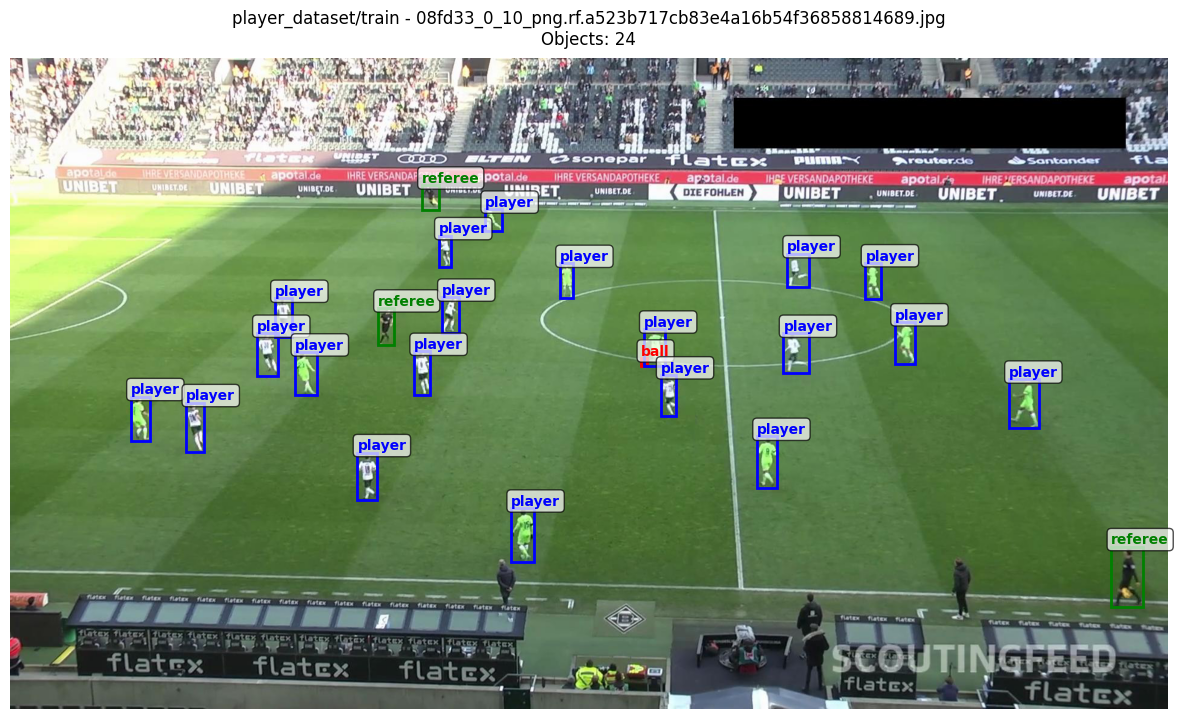


=== Validation Set Sample ===


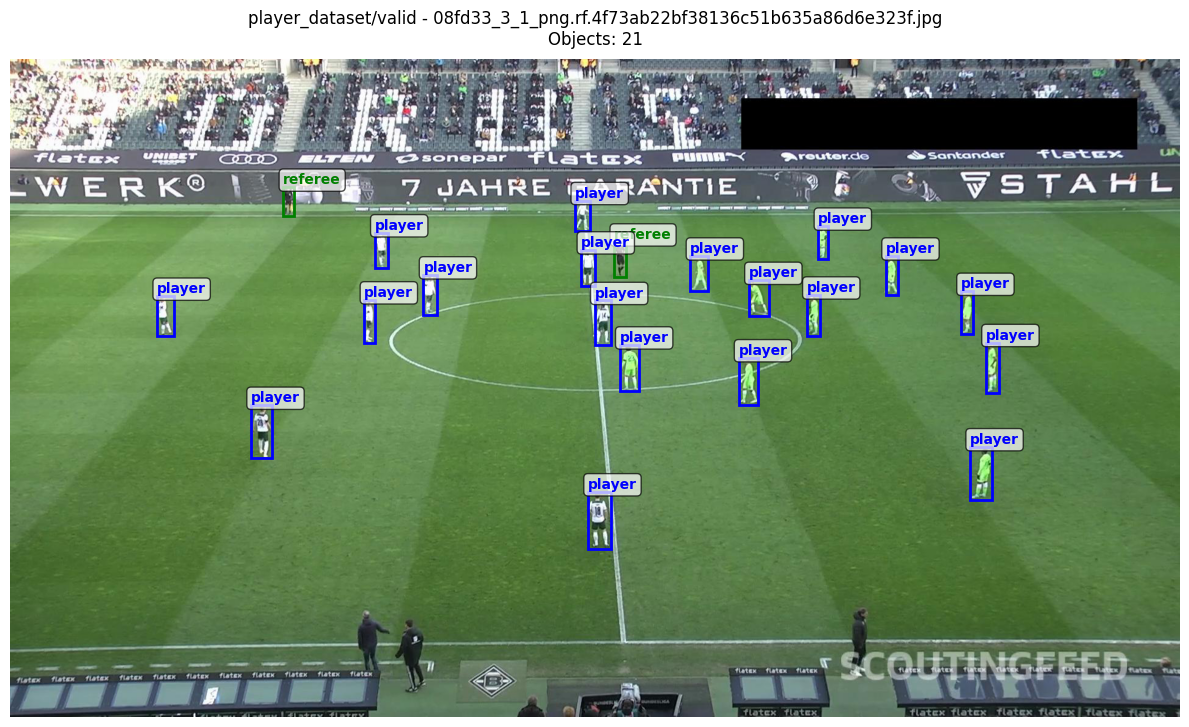


=== Test Set Sample ===


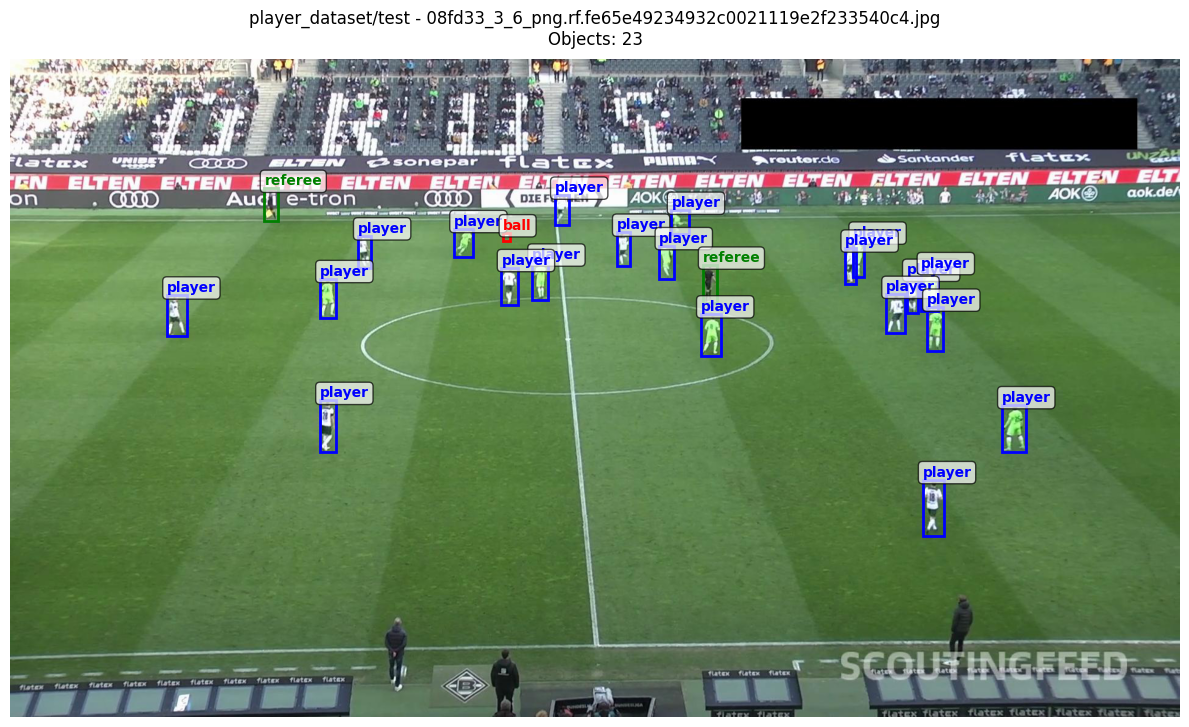

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Define colors for each class
CLASS_COLORS = {
    'ball': 'red',
    'goalkeeper': 'yellow',
    'player': 'blue',
    'referee': 'green'
}

def visualize_sample(df, idx, figsize=(12, 8)):
    """
    Visualize an image with its bounding boxes.
    """
    row = df.iloc[idx]
    
    # Load image
    img = Image.open(row['image_path'])
    img_width, img_height = img.size
    
    # Create figure
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    
    # Draw bounding boxes
    for ann in row['annotations']:
        # Convert from YOLO format to corner format
        x_center = ann['x_center'] * img_width
        y_center = ann['y_center'] * img_height
        width = ann['width'] * img_width
        height = ann['height'] * img_height
        
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        
        color = CLASS_COLORS[ann['class_name']]
        
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        
        ax.text(
            x_min, y_min - 5,
            ann['class_name'],
            color=color,
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )
    
    ax.axis('off')
    ax.set_title(f"{row['split']} - {row['filename']}\nObjects: {row['num_objects']}", fontsize=12, pad=10)
    plt.tight_layout()
    plt.show()

# Visualize samples
print("=== Training Set Sample ===")
visualize_sample(train_df, 0)

print("\n=== Validation Set Sample ===")
visualize_sample(valid_df, 0)

print("\n=== Test Set Sample ===")
visualize_sample(test_df, 0)


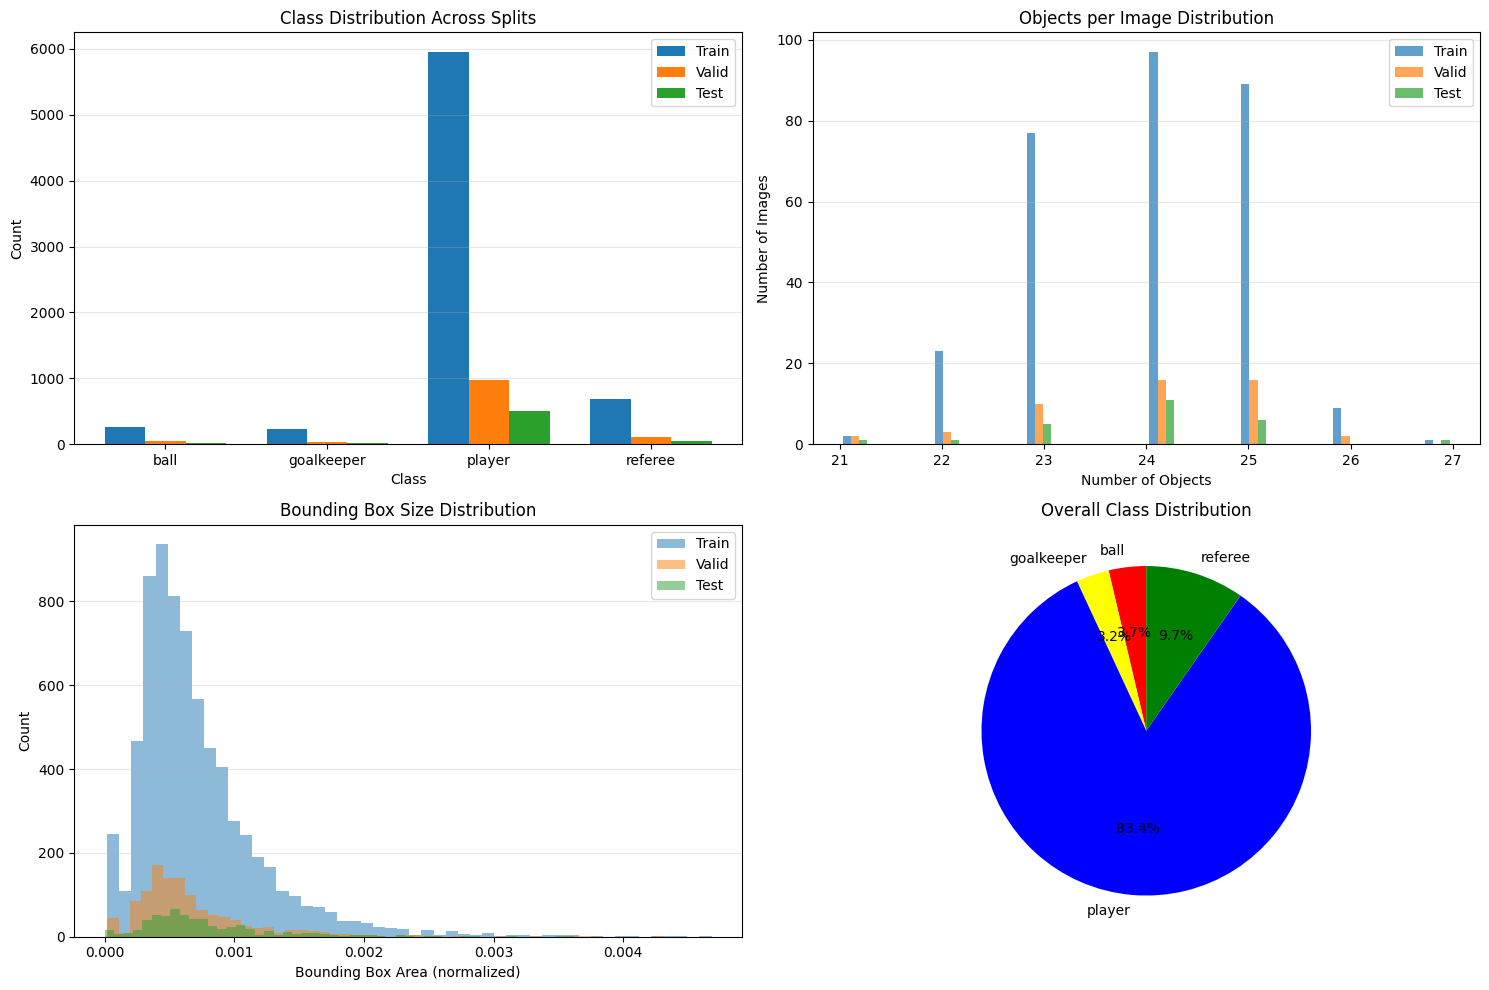


=== Summary Statistics ===
Total dataset size: 372 images
Total objects: 8906

Class imbalance ratio:
  ball: 327 (4.40% of most common class)
  goalkeeper: 288 (3.88% of most common class)
  player: 7428 (100.00% of most common class)
  referee: 863 (11.62% of most common class)


In [23]:
# Class distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Class distribution across splits
class_counts = {}
for split_name, df in [('Train', train_df), ('Valid', valid_df), ('Test', test_df)]:
    class_counts[split_name] = [df[f'num_{cls}s'].sum() for cls in CLASS_NAMES]

x = np.arange(len(CLASS_NAMES))
width = 0.25

ax = axes[0, 0]
for i, (split_name, counts) in enumerate(class_counts.items()):
    ax.bar(x + i * width, counts, width, label=split_name)

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution Across Splits')
ax.set_xticks(x + width)
ax.set_xticklabels(CLASS_NAMES)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Objects per image distribution
ax = axes[0, 1]
ax.hist([train_df['num_objects'], valid_df['num_objects'], test_df['num_objects']], 
        label=['Train', 'Valid', 'Test'], bins=20, alpha=0.7)
ax.set_xlabel('Number of Objects')
ax.set_ylabel('Number of Images')
ax.set_title('Objects per Image Distribution')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Bounding box size distribution (area)
ax = axes[1, 0]
for split_name, df in [('Train', train_df), ('Valid', valid_df), ('Test', test_df)]:
    all_areas = []
    for anns in df['annotations']:
        for ann in anns:
            area = ann['width'] * ann['height']  # Normalized area
            all_areas.append(area)
    ax.hist(all_areas, bins=50, alpha=0.5, label=split_name)

ax.set_xlabel('Bounding Box Area (normalized)')
ax.set_ylabel('Count')
ax.set_title('Bounding Box Size Distribution')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 4. Class distribution pie chart (combined)
ax = axes[1, 1]
all_df = pd.concat([train_df, valid_df, test_df])
total_per_class = [all_df[f'num_{cls}s'].sum() for cls in CLASS_NAMES]
colors_list = [CLASS_COLORS[cls] for cls in CLASS_NAMES]

ax.pie(total_per_class, labels=CLASS_NAMES, autopct='%1.1f%%', 
       colors=colors_list, startangle=90)
ax.set_title('Overall Class Distribution')

plt.tight_layout()
plt.show()

print("\n=== Summary Statistics ===")
print(f"Total dataset size: {len(train_df) + len(valid_df) + len(test_df)} images")
print(f"Total objects: {sum(total_per_class)}")
print(f"\nClass imbalance ratio:")
max_count = max(total_per_class)
for cls, count in zip(CLASS_NAMES, total_per_class):
    ratio = count / max_count
    print(f"  {cls}: {count} ({ratio:.2%} of most common class)")


#### 2. Data Preprocessing

##### 2.1. Random image augmentation (rotation)

In [24]:
import cv2
import random
from PIL import Image
import shutil

def rotate_bbox_90(x_center, y_center, width, height, angle):
    """
    Rotate bounding box coordinates for 90, 180, or 270 degree rotations.
    """
    if angle == 90:
        new_x_center = 1 - y_center
        new_y_center = x_center
        new_width = height
        new_height = width
    elif angle == 180:
        new_x_center = 1 - x_center
        new_y_center = 1 - y_center
        new_width = width
        new_height = height
    elif angle == 270:
        new_x_center = y_center
        new_y_center = 1 - x_center
        new_width = height
        new_height = width
    else:
        raise ValueError(f"Angle must be 90, 180, or 270, got {angle}")
    
    return new_x_center, new_y_center, new_width, new_height

def rotate_image_90(image_path, angle):
    """
    Rotate an image by 90, 180, or 270 degrees.
    """
    img = Image.open(image_path)
    
    if angle == 90:
        rotated = img.rotate(-90, expand=True)
    elif angle == 180:
        rotated = img.rotate(-180, expand=True)
    elif angle == 270:
        rotated = img.rotate(-270, expand=True)
    else:
        raise ValueError(f"Angle must be 90, 180, or 270, got {angle}")
    
    return rotated

def augment_dataset_with_rotations(df, split_name, augmentation_prob=0.5, rotation_angles=[90, 180, 270]):
    """
    Apply random rotation augmentations to a dataset split.
    """
    augmented_data = []
    
    # Create augmented directories
    aug_images_dir = 'player_dataset' / Path(split_name) / 'images_augmented'
    aug_labels_dir = 'player_dataset' / Path(split_name) / 'labels_augmented'
    aug_images_dir.mkdir(exist_ok=True)
    aug_labels_dir.mkdir(exist_ok=True)
    
    print(f"\nAugmenting {split_name} set...")
    
    for idx, row in df.iterrows():
        if random.random() < augmentation_prob:
            angle = random.choice(rotation_angles)
            
            original_img_path = row['image_path']
            rotated_img = rotate_image_90(original_img_path, angle)
            
            base_filename = Path(row['filename']).stem
            new_filename = f"{base_filename}_rot{angle}.jpg"
            new_img_path = aug_images_dir / new_filename
            new_label_path = aug_labels_dir / f"{base_filename}_rot{angle}.txt"
            
            rotated_img.save(new_img_path)
            
            rotated_annotations = []
            with open(new_label_path, 'w') as f:
                for ann in row['annotations']:
                    new_x, new_y, new_w, new_h = rotate_bbox_90(
                        ann['x_center'], ann['y_center'],
                        ann['width'], ann['height'],
                        angle
                    )
                    
                    f.write(f"{ann['class_id']} {new_x} {new_y} {new_w} {new_h}\n")
                    
                    rotated_annotations.append({
                        'class_id': ann['class_id'],
                        'class_name': ann['class_name'],
                        'x_center': new_x,
                        'y_center': new_y,
                        'width': new_w,
                        'height': new_h
                    })
            
            augmented_data.append({
                'image_path': str(new_img_path),
                'label_path': str(new_label_path),
                'filename': new_filename,
                'split': split_name,
                'annotations': rotated_annotations,
                'augmented': True,
                'augmentation_type': f'rotation_{angle}'
            })
            
            if (idx + 1) % 50 == 0:
                print(f"  Processed {idx + 1}/{len(df)} images...")
    
    print(f"  Created {len(augmented_data)} augmented samples")
    
    if augmented_data:
        aug_df = pd.DataFrame(augmented_data)
        aug_df['num_objects'] = aug_df['annotations'].apply(len)
        for class_id, class_name in enumerate(CLASS_NAMES):
            aug_df[f'num_{class_name}s'] = aug_df['annotations'].apply(
                lambda anns: sum(1 for ann in anns if ann['class_id'] == class_id)
            )
        
        df_copy = df.copy()
        df_copy['augmented'] = False
        df_copy['augmentation_type'] = 'original'
        
        combined_df = pd.concat([df_copy, aug_df], ignore_index=True)
        return combined_df
    else:
        df_copy = df.copy()
        df_copy['augmented'] = False
        df_copy['augmentation_type'] = 'original'
        return df_copy

print("Augmentation functions defined successfully!")


Augmentation functions defined successfully!


In [25]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("=" * 70)
print("APPLYING ROTATION AUGMENTATIONS")
print("=" * 70)

# Apply augmentation to training set (50% of images)
train_df_augmented = augment_dataset_with_rotations(
    train_df, 
    'train', 
    augmentation_prob=0.5,
    rotation_angles=[90, 180, 270]
)

# Apply augmentation to validation set (30% of images)
valid_df_augmented = augment_dataset_with_rotations(
    valid_df, 
    'valid', 
    augmentation_prob=0.3,
    rotation_angles=[90, 180, 270]
)

# Apply augmentation to test set (30% of images)
test_df_augmented = augment_dataset_with_rotations(
    test_df, 
    'test', 
    augmentation_prob=0.3,
    rotation_angles=[90, 180, 270]
)

print("\n" + "=" * 70)
print("AUGMENTATION COMPLETE")
print("=" * 70)

# Display updated statistics
print("\n=== UPDATED DATASET STATISTICS (with augmentation) ===")
for split_name, df in [('Train', train_df_augmented), ('Validation', valid_df_augmented), ('Test', test_df_augmented)]:
    original_count = len(df[df['augmented'] == False])
    augmented_count = len(df[df['augmented'] == True])
    
    print(f"\n{split_name} Set:")
    print(f"  Original images: {original_count}")
    print(f"  Augmented images: {augmented_count}")
    print(f"  Total images: {len(df)}")
    print(f"  Total objects: {df['num_objects'].sum()}")
    print(f"  Avg objects per image: {df['num_objects'].mean():.2f}")
    print(f"  Objects per class:")
    for class_name in CLASS_NAMES:
        total = df[f'num_{class_name}s'].sum()
        print(f"    {class_name}: {total}")
    
    # Show augmentation type distribution
    if augmented_count > 0:
        print(f"  Augmentation types:")
        for aug_type in df[df['augmented'] == True]['augmentation_type'].value_counts().items():
            print(f"    {aug_type[0]}: {aug_type[1]} images")

# Update the original dataframes with augmented versions
train_df = train_df_augmented
valid_df = valid_df_augmented
test_df = test_df_augmented

print("\n✓ DataFrames updated with augmented data!")


APPLYING ROTATION AUGMENTATIONS

Augmenting train set...
  Processed 50/298 images...
  Created 148 augmented samples

Augmenting valid set...
  Created 10 augmented samples

Augmenting test set...
  Created 12 augmented samples

AUGMENTATION COMPLETE

=== UPDATED DATASET STATISTICS (with augmentation) ===

Train Set:
  Original images: 298
  Augmented images: 148
  Total images: 446
  Total objects: 10687
  Avg objects per image: 23.96
  Objects per class:
    ball: 389
    goalkeeper: 348
    player: 8911
    referee: 1039
  Augmentation types:
    rotation_270: 63 images
    rotation_90: 45 images
    rotation_180: 40 images

Validation Set:
  Original images: 49
  Augmented images: 10
  Total images: 59
  Total objects: 1413
  Avg objects per image: 23.95
  Objects per class:
    ball: 54
    goalkeeper: 45
    player: 1173
    referee: 141
  Augmentation types:
    rotation_90: 5 images
    rotation_270: 4 images
    rotation_180: 1 images

Test Set:
  Original images: 25
  Augmen

VISUALIZING ORIGINAL VS AUGMENTED IMAGES

Showing original images with their rotated augmentations...
(Colors: Red=ball, Yellow=goalkeeper, Blue=player, Green=referee)


--- Training Example 1 ---


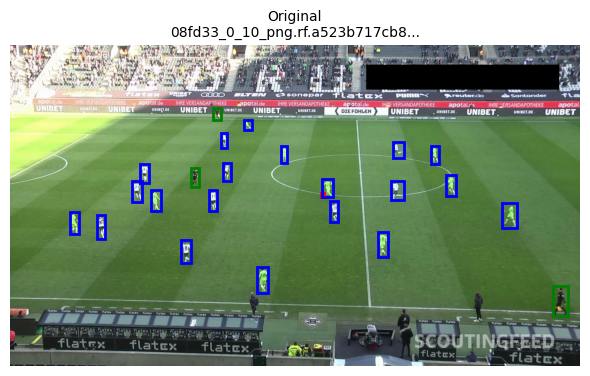


--- Training Example 2 ---


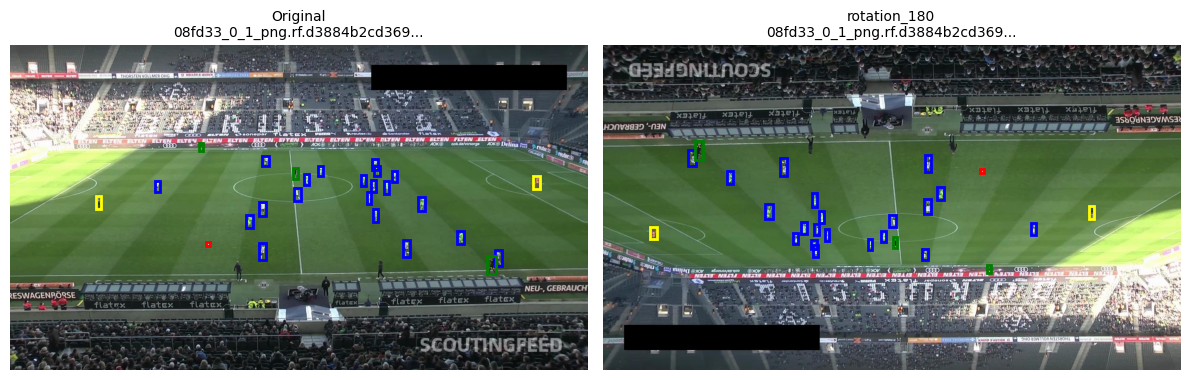


--- Training Example 3 ---


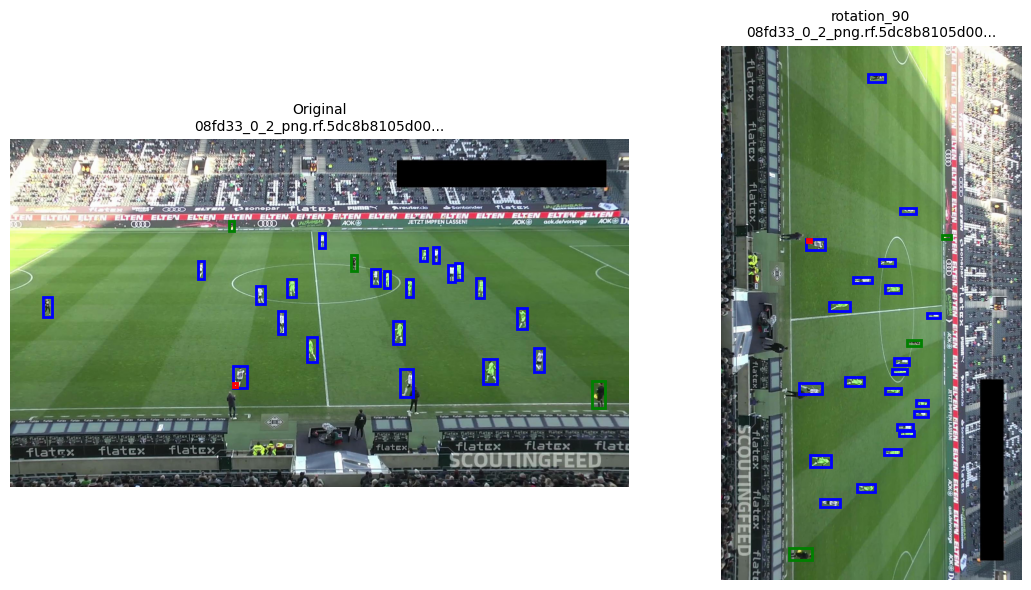

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define colors for each class
CLASS_COLORS = {
    'ball': 'red',
    'goalkeeper': 'yellow',
    'player': 'blue',
    'referee': 'green'
}

def visualize_original_vs_augmented(df, original_idx):
    """
    Visualize an original image and its augmented versions side by side.
    """
    # Get original image
    original_row = df[(df['augmented'] == False)].iloc[original_idx]
    original_filename_stem = Path(original_row['filename']).stem
    
    # Find augmented versions
    augmented_rows = df[
        (df['augmented'] == True) & 
        (df['filename'].str.contains(original_filename_stem))
    ]
    
    # Create subplots
    num_images = 1 + len(augmented_rows)
    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
    
    if num_images == 1:
        axes = [axes]
    
    # Plot original
    img = Image.open(original_row['image_path'])
    img_width, img_height = img.size
    axes[0].imshow(img)
    
    for ann in original_row['annotations']:
        x_center = ann['x_center'] * img_width
        y_center = ann['y_center'] * img_height
        width = ann['width'] * img_width
        height = ann['height'] * img_height
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        
        color = CLASS_COLORS[ann['class_name']]
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        axes[0].add_patch(rect)
    
    axes[0].axis('off')
    axes[0].set_title(f"Original\n{original_row['filename'][:30]}...", fontsize=10)
    
    # Plot augmented versions
    for idx, (_, aug_row) in enumerate(augmented_rows.iterrows(), start=1):
        img = Image.open(aug_row['image_path'])
        img_width, img_height = img.size
        axes[idx].imshow(img)
        
        for ann in aug_row['annotations']:
            x_center = ann['x_center'] * img_width
            y_center = ann['y_center'] * img_height
            width = ann['width'] * img_width
            height = ann['height'] * img_height
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            
            color = CLASS_COLORS[ann['class_name']]
            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            axes[idx].add_patch(rect)
        
        axes[idx].axis('off')
        axes[idx].set_title(f"{aug_row['augmentation_type']}\n{aug_row['filename'][:30]}...", fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("=" * 70)
print("VISUALIZING ORIGINAL VS AUGMENTED IMAGES")
print("=" * 70)
print("\nShowing original images with their rotated augmentations...")
print("(Colors: Red=ball, Yellow=goalkeeper, Blue=player, Green=referee)\n")

# Visualize a few examples from training set
for i in range(min(3, len(train_df[train_df['augmented'] == False]))):
    print(f"\n--- Training Example {i+1} ---")
    visualize_original_vs_augmented(train_df, i)


In [27]:
# Save augmented dataframes to CSV for future reference
print("=" * 70)
print("SAVING AUGMENTED DATASET INFORMATION")
print("=" * 70)

train_df.to_csv('train_augmented.csv', index=False)
valid_df.to_csv('valid_augmented.csv', index=False)
test_df.to_csv('test_augmented.csv', index=False)

print("\n✓ Saved augmented dataset info to CSV files:")
print("  - player_dataset/train_augmented.csv")
print("  - player_dataset/valid_augmented.csv")
print("  - player_dataset/test_augmented.csv")

SAVING AUGMENTED DATASET INFORMATION

✓ Saved augmented dataset info to CSV files:
  - player_dataset/train_augmented.csv
  - player_dataset/valid_augmented.csv
  - player_dataset/test_augmented.csv
